# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [40]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Sorting data according to Time in ascending order
final = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,948672000,A sure death for flies,I bought a few of these after my apartment was...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...
28086,30629,B00008RCMI,A19E94CF5O1LY7,Andrew Arnold,0,0,1,1067040000,"I've chewed this gum many times, but used?","Nothing against the product, but it does bothe..."
28087,30630,B00008RCMI,A284C7M23F0APC,A. Mendoza,0,0,1,1067040000,Best sugarless gum ever!,I love this stuff. It is sugar-free so it does...


In [11]:
#Shape of final dataset
final.shape

(87775, 10)

In [12]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [13]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [14]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [15]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [16]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.
we use this as the base, then besides the chicken, we will also add pasta, spices, veggies, or whatever we have around to make quick cheesy meals
My dogs just love this food. The service is always fast and reliable.
I am amazed by how well this tea works to relieve my chronic congestion and recurring sinus problems. And it's not just a "quick" fix either -- its therapeutic effects last for hours. I was a bit worried the tea would be a bit too "licorice-y" since one of its main ingredients is licorice root, but the fragrance and taste are mild and incredibly soothing. If you think this package of six boxes is too much, you'll be ha

In [17]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.


In [18]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had "attracted" many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.
we use this as the base, then besides the chicken, we will also add pasta, spices, veggies, or whatever we have around to make quick cheesy meals
My dogs just love this food. The service is always fast and reliable.
I am amazed by how well this tea works to relieve my chronic congestion and recurring sinus problems. And it's not just a "quick" fix either -- its therapeutic effects last for hours. I was a bit worried the tea would be a bit too "licorice-y" since one of its main ingredients is licorice root, but the fragrance and taste are mild and incredibly soothing. If you think this package of six boxes is too much, you'll be happily prov

In [19]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [20]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

My dogs just love this food. The service is always fast and reliable.


In [21]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.


In [22]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

My dogs just love this food The service is always fast and reliable 


In [23]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [24]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [01:16<00:00, 1150.45it/s]


In [25]:
preprocessed_reviews[1500]

'dogs love food service always fast reliable'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [26]:
## Similartly you can do preprocessing for review summary also.
## Similartly you can do preprocessing for review summary also.
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:44<00:00, 1951.41it/s]


# [4] Featurization

## [4.1] BAG OF WORDS

In [27]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 54904)
the number of unique words  54904


## [4.2] Bi-Grams and n-Grams.

In [28]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [29]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able brew']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (87773, 51709)
the number of unique words including both unigrams and bigrams  51709


## [4.4] Word2Vec

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

#### [4.4.1.2] TFIDF weighted W2v

# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [65]:
# Please write all the code with proper documentation

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.model_selection  import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection  import cross_val_score
from sklearn.preprocessing import StandardScaler
from collections import Counter


X=preprocessed_reviews

y=np.array(final['Score'])
# Added additional parameter "shuffle=False" for time based splitting
X_1, X_test, Y_1, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
X_train, X_cv, y_train, y_cv = train_test_split(X_1, Y_1, test_size=0.3)

X_train shape =  (43008, 38541)
X_test shape =  (26332, 38541)
X_cv shape =  (18433, 38541)


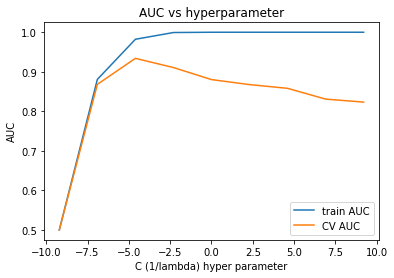

optimal lambda for which auc is maximum :  99.0


In [31]:
# Please write all the code with proper documentation
count_vect = CountVectorizer()
X_train=count_vect.fit_transform(X_train)
X_cv=count_vect.transform(X_cv)
X_test=count_vect.transform(X_test)

scalar = StandardScaler(with_mean=False)
X_train = scalar.fit_transform(X_train)
X_test= scalar.transform(X_test)
X_cv=scalar.transform(X_cv)

print ('X_train shape = ', X_train.shape)
print ('X_test shape = ', X_test.shape)
print ('X_cv shape = ', X_cv.shape)

C = [10**-4, 10**-3, 10**-2, 10 **-1, 10**0, 10**1, 10**2,10**3,10**4]

train_auc=[]
cv_auc=[]
for c in C:
    #Added additional parameter class_weight='balanced'. The “balanced” mode uses the values of y to automatically 
    #adjust weights inversely proportional to class
    log_regression=LogisticRegression(penalty='l1',C=c, class_weight='balanced')
    log_regression.fit(X_train,y_train)
    probcv=log_regression.predict_proba(X_cv)[:,1]
    cv_auc.append(roc_auc_score(y_cv,probcv))
    probtr=log_regression.predict_proba(X_train)[:,1]
    train_auc.append(roc_auc_score(y_train,probtr))
optimal_c= C[cv_auc.index(max(cv_auc))]
#converting into log values
C=[math.log(x) for x in C]
fig = plt.figure()
axis = plt.subplot(111)
axis.plot(C, train_auc, label='train AUC')
axis.plot(C, cv_auc, label='CV AUC')
plt.title('AUC vs hyperparameter')
plt.xlabel('C (1/lambda) hyper parameter')
plt.ylabel('AUC')
axis.legend()
plt.show()
print('optimal lambda for which auc is maximum : ',1//optimal_c)

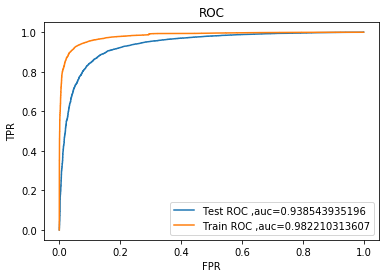

In [32]:
#ROC for optimal lambda=99
'''Added additional parameter class_weight='balanced'. The “balanced” mode uses the values of y to automatically 
adjust weights inversely proportional to class'''
log_regression=LogisticRegression(penalty='l1',C=optimal_c, class_weight='balanced')
log_regression.fit(X_train,y_train)
test_predict=log_regression.predict_proba(X_test)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, test_predict)
train_predict=log_regression.predict_proba(X_train)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_train,train_predict)
fig = plt.figure()
axis = plt.subplot(111)
axis.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,test_predict)))
axis.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,train_predict)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
axis.legend()
plt.show()

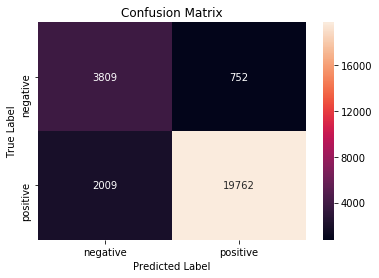

In [33]:
#Confusion matrix on train and test data
import seaborn as sns
log_regression=LogisticRegression(penalty='l1',C=optimal_c,class_weight='balanced')
log_regression.fit(X_train,y_train)
predict=log_regression.predict(X_test)

confusion_matrix = confusion_matrix(y_test, predict)
class_label = ["negative", "positive"]
df = pd.DataFrame(confusion_matrix, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d", linecolor="white")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [34]:
# Please write all the code with proper documentation
#l1 regularization
'''Added additional parameter class_weight='balanced'. The “balanced” mode uses the values of y to automatically 
adjust weights inversely proportional to class'''
log_regression=LogisticRegression(penalty='l1',C=optimal_c, class_weight='balanced')
log_regression.fit(X_train,y_train)
weight=log_regression.coef_
print('Non zero element count in weight vector ',np.count_nonzero(weight))

Non zero element count in weight vector  3640


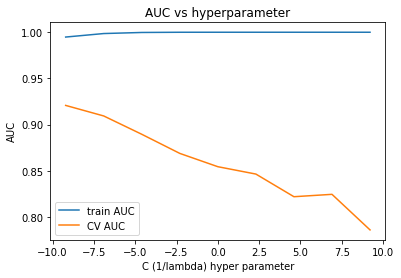

optimal lambda for which auc is maximum :  9999.0


In [37]:
# Please write all the code with proper documentation
count_vect = CountVectorizer()
X_train=count_vect.fit_transform(X_train)
X_cv=count_vect.transform(X_cv)
X_test=count_vect.transform(X_test)

scalar = StandardScaler(with_mean=False)
X_train = scalar.fit_transform(X_train)
X_test= scalar.transform(X_test)
X_cv=scalar.transform(X_cv)

C = [10**-4, 10**-3, 10**-2, 10 **-1, 10**0, 10**1, 10**2,10**3,10**4]
train_auc=[]
cv_auc=[]
for c in C:
    '''Added additional parameter class_weight='balanced'. The “balanced” mode uses the values of y to automatically 
adjust weights inversely proportional to class'''
    log_regression=LogisticRegression(penalty='l2',C=c, class_weight='balanced')
    log_regression.fit(X_train,y_train)
    probcv=log_regression.predict_proba(X_cv)[:,1]
    cv_auc.append(roc_auc_score(y_cv,probcv))
    probtr=log_regression.predict_proba(X_train)[:,1]
    train_auc.append(roc_auc_score(y_train,probtr))
optimal_c= C[cv_auc.index(max(cv_auc))]
C=[math.log(x) for x in C]#converting values of C into logarithm
fig = plt.figure()
axis = plt.subplot(111)
axis.plot(C, train_auc, label='train AUC')
axis.plot(C, cv_auc, label='CV AUC')
plt.title('AUC vs hyperparameter')
plt.xlabel('C (1/lambda) hyper parameter')
plt.ylabel('AUC')
axis.legend()
plt.show()
print('optimal lambda for which auc is maximum : ',1//optimal_c)

### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

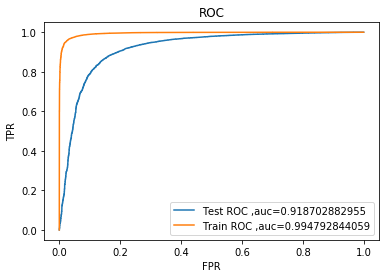

In [38]:
#ROC
'''Added additional parameter class_weight='balanced'. The “balanced” mode uses the values of y to automatically 
adjust weights inversely proportional to class'''
log_regression=LogisticRegression(penalty='l2',C=optimal_c, class_weight='balanced')
log_regression.fit(X_train,y_train)
test_predict=log_regression.predict_proba(X_test)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, test_predict)
train_predict=log_regression.predict_proba(X_train)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_train,train_predict)
fig = plt.figure()
axis = plt.subplot(111)
axis.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,test_predict)))
axis.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,train_predict)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
axis.legend()
plt.show()

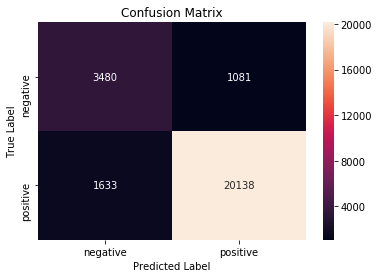

In [41]:
#confusion matrix
import seaborn as sns
log_regression=LogisticRegression(penalty='l2',C=optimal_c,class_weight='balanced')
log_regression.fit(X_train,y_train)
predict=log_regression.predict(X_test)
conf_mat = confusion_matrix(y_test, predict)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [56]:
# Please write all the code with proper documentation
#for checking multicollinearity we add e(small value) to train vector
W_before=log_regression.coef_
X_tr=X_train
X_tr.data=X_tr.data+np.random.normal(loc=0,scale=0.0001,size=X_tr.data.shape)

print (X_tr.shape)

(43008, 38457)


In [57]:
#Training Logistic regression with X_tr
#Applying l2 regularization
lr_tr=LogisticRegression(penalty='l2',C=optimal_c, class_weight='balanced')
lr_tr.fit(X_tr,y_train)
W_after=lr_tr.coef_

#to eliminate divisible by zero error we will add 10^-6 to W_before and W_after
W_before+=10**-6
W_after+=10**-6

per_vector=[]

for i in range(len(W_before[0])):
    val=W_after[0][i]-W_before[0][i]
    val/=W_before[0][i]
    per_vector.append(val)
    
original_per_vect=np.absolute(per_vector)    
per_vector=sorted(np.absolute(per_vector))[::-1]

per_vector[:10]

[6.0644078829416417,
 3.2414915151831383,
 2.164480361529117,
 2.1644763215327454,
 2.1644756093885222,
 1.0477209657179241,
 0.92021826241822813,
 0.67756785642202744,
 0.64266408982234524,
 0.64266406308372992]

In [58]:

#calculating percentiles from 0 to 100

for i in range(11):
    print(str(i*10)+'th percentile = '+str(np.percentile(per_vector,i*10)))

0th percentile = 5.79925488841e-06
10th percentile = 0.000170374790208
20th percentile = 0.000251422473182
30th percentile = 0.00033192383961
40th percentile = 0.000420015298543
50th percentile = 0.000528336017911
60th percentile = 0.000686830999603
70th percentile = 0.000941418958327
80th percentile = 0.00145812870775
90th percentile = 0.0033370139477
100th percentile = 6.06440788294


In [59]:
#there is sudden rise in percentile from 90 to 100
#calculating percentile from 90 to 100
for i in range(90,101):
    print(str(i)+'th percentile ='+str(np.percentile(per_vector,i)))

90th percentile =0.0033370139477
91th percentile =0.00377733621667
92th percentile =0.00443955033238
93th percentile =0.00517761598633
94th percentile =0.00651600029173
95th percentile =0.00841795226978
96th percentile =0.0118014089504
97th percentile =0.019316573659
98th percentile =0.0380652395706
99th percentile =0.198499498512
100th percentile =6.06440788294


In [60]:
#from 99th percentile to 100 percentile sudden rise
#calculating percentile from 99.1 to 100
for i in range(1,11):
    print(str(99+(10**-1)*i)+'th percentile ='+str(np.percentile(per_vector,99+(10**-1)*i)))

99.1th percentile =0.240021640789
99.2th percentile =0.282617899208
99.3th percentile =0.301392709437
99.4th percentile =0.338663184256
99.5th percentile =0.413218586951
99.6th percentile =0.469598328356
99.7th percentile =0.491033645886
99.8th percentile =0.509976081776
99.9th percentile =0.642663601192
100.0th percentile =6.06440788294


In [61]:
# Please write all the code with proper documentation
original_per_vect=original_per_vect.tolist()
all_features = count_vect.get_feature_names()

for i in range(0,4):
    indx=original_per_vect.index(np.percentile(per_vector,99.9+(10**-1)*i))
    print(all_features[indx])


chocoperfection
chocs
choice
choices


### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>


#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [62]:
# Please write all the code with proper documentation

weight=log_regression.coef_
pos_indx=np.argsort(weight)[:,::-1]

neg_indx=np.argsort(weight)

print('Top 10 positive features :')
for i in list(pos_indx[0][0:10]):
    print(all_features[i])

Top 10 positive features :
great
best
love
delicious
good
loves
perfect
favorite
excellent
nice


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [63]:
# Please write all the code with proper documentation
print('Top 10 negative features :')
for i in list(neg_indx[0][0:10]):
    print(all_features[i])

Top 10 negative features :
not
disappointed
bad
worst
terrible
horrible
waste
disappointing
awful
threw


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=10,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)
X_train_tf shape =  (43008, 25426)
X_cv shape =  (18433, 25426)
X_test_tf shape =  (26332, 25426)


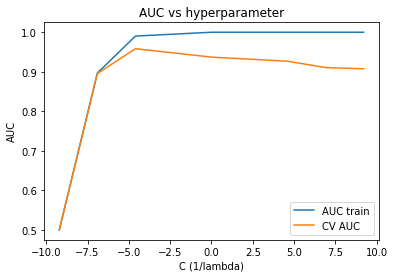

In [66]:
# Please write all the code with proper documentation
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, lowercase=False)
print (tf_idf_vect)
X_train_tf=tf_idf_vect.fit_transform(X_train)
X_cv_tf=tf_idf_vect.transform(X_cv)
X_test_tf=tf_idf_vect.transform(X_test)

print ('X_train_tf shape = ', X_train_tf.shape)
print ('X_cv shape = ', X_cv_tf.shape)
print ('X_test_tf shape = ', X_test_tf.shape)

# Standardizing the data
scalar = StandardScaler(with_mean=False)
X_train_tf = scalar.fit_transform(X_train_tf)
X_test_tf= scalar.transform(X_test_tf)
X_cv_tf=scalar.transform(X_cv_tf)

#C=1/lambda
C = [10**-4, 10**-3, 10**-2, 10**0, 10**2,10**3,10**4]
train_auc=[]
cv_auc=[]
for c in C:
    '''Added additional parameter class_weight='balanced'. The “balanced” mode uses the values of y to automatically 
adjust weights inversely proportional to class'''
    log_regression=LogisticRegression(penalty='l1',C=c, class_weight='balanced')
    log_regression.fit(X_train_tf,y_train)
    probcv=log_regression.predict_proba(X_cv_tf)[:,1]
    cv_auc.append(roc_auc_score(y_cv,probcv))
    probtr=log_regression.predict_proba(X_train_tf)[:,1]
    train_auc.append(roc_auc_score(y_train,probtr))
optimal_c= C[cv_auc.index(max(cv_auc))]
#converting into logorithm values
C=[math.log(x) for x in C]
fig = plt.figure()
axis = plt.subplot(111)
axis.plot(C, train_auc, label='AUC train')
axis.plot(C, cv_auc, label='CV AUC')
plt.title('AUC vs hyperparameter')
plt.xlabel('C (1/lambda)')
plt.ylabel('AUC')
axis.legend()
plt.show()

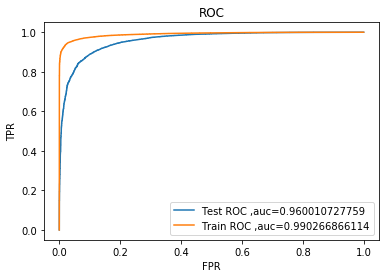

In [67]:
#ROC
'''Added additional parameter class_weight='balanced'. The “balanced” mode uses the values of y to automatically 
adjust weights inversely proportional to class'''
log_regression=LogisticRegression(penalty='l1',C=optimal_c, class_weight='balanced')
log_regression.fit(X_train_tf,y_train)
test_predict=log_regression.predict_proba(X_test_tf)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, test_predict)
train_predict=log_regression.predict_proba(X_train_tf)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_train,train_predict)
fig = plt.figure()
axis = plt.subplot(111)
axis.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,test_predict)))
axis.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,train_predict)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
axis.legend()
plt.show()

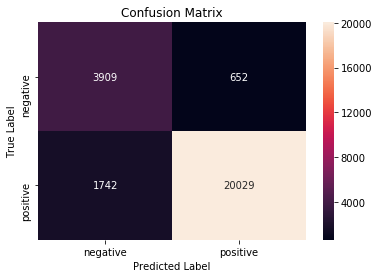

In [68]:
#confusion matrix
import seaborn as sns
log_regression=LogisticRegression(penalty='l1',C=optimal_c, class_weight='balanced')
log_regression.fit(X_train_tf,y_train)
predict=log_regression.predict(X_test_tf)
conf_mat = confusion_matrix(y_test, predict)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

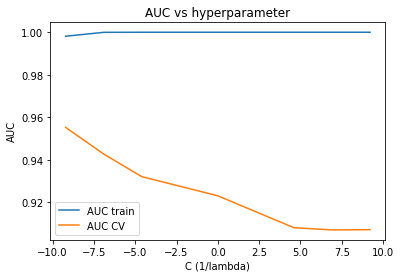

optimal lambda for which auc is maximum :  9999.0


In [69]:
# Please write all the code with proper documentation
C = [10**-4,10**-3, 10**-2, 10**0, 10**2,10**3,10**4]
train_auc=[]
cv_auc=[]
for c in C:
    '''Added additional parameter class_weight='balanced'. The “balanced” mode uses the values of y to automatically 
adjust weights inversely proportional to class'''
    log_regression=LogisticRegression(penalty='l2',C=c, class_weight='balanced')
    log_regression.fit(X_train_tf,y_train)
    probcv=log_regression.predict_proba(X_cv_tf)[:,1]
    cv_auc.append(roc_auc_score(y_cv,probcv))
    probtr=log_regression.predict_proba(X_train_tf)[:,1]
    train_auc.append(roc_auc_score(y_train,probtr))
optimal_c= C[cv_auc.index(max(cv_auc))]
C=[math.log(x) for x in C]#converting values of C into logarithm
fig = plt.figure()
axis = plt.subplot(111)
axis.plot(C, train_auc, label='AUC train')
axis.plot(C, cv_auc, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('C (1/lambda)')
plt.ylabel('AUC')
axis.legend()
plt.show()
print('optimal lambda for which auc is maximum : ',1//optimal_c)

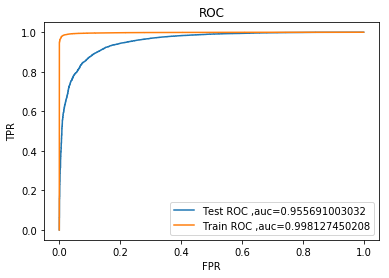

In [70]:
#ROC for lambda=9999
'''Added additional parameter class_weight='balanced'. The “balanced” mode uses the values of y to automatically 
adjust weights inversely proportional to class'''
log_regression=LogisticRegression(penalty='l2',C=optimal_c, class_weight='balanced')
log_regression.fit(X_train_tf,y_train)
predi=log_regression.predict_proba(X_test_tf)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, predi)
pred=log_regression.predict_proba(X_train_tf)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_train,pred)
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,predi)))
ax.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()

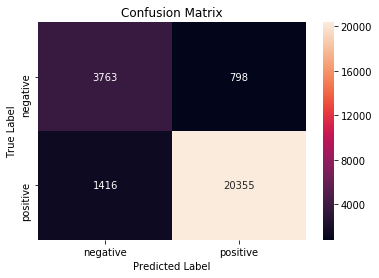

In [71]:
#confusion matrix
lr=LogisticRegression(penalty='l2',C=optimal_c, class_weight='balanced')
lr.fit(X_train_tf,y_train)
predict=lr.predict(X_test_tf)
conf_mat = confusion_matrix(y_test, predict)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [72]:
# Please write all the code with proper documentation
all_features = tf_idf_vect.get_feature_names()
weight=log_regression.coef_
pos_indx=np.argsort(weight)[:,::-1]

neg_indx=np.argsort(weight)

print('Top 10 positive features :')
for i in list(pos_indx[0][0:10]):
    print(all_features[i])

Top 10 positive features :
great
love
best
good
delicious
perfect
loves
favorite
nice
excellent


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [73]:
# Please write all the code with proper documentation
print('Top 10 negative features :')
for i in list(neg_indx[0][:10]):
    print(all_features[i])

Top 10 negative features :
disappointed
not
not buy
not good
not worth
terrible
worst
horrible
disappointing
not recommend


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [74]:
# Please write all the code with proper documentation
#word2vec for train
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
sent_vectors_train = []; 
for sent in tqdm(list_of_sentance_train):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))


100%|███████████████████████████████████████████████████████████████████████████| 43008/43008 [01:36<00:00, 446.99it/s]


43008
50


In [75]:
#for cross validation we can use same w2v models and w2v words
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
sent_vectors_cv = []; 
for sent in tqdm(list_of_sentance_cv):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0])) 

100%|███████████████████████████████████████████████████████████████████████████| 18433/18433 [00:41<00:00, 445.52it/s]


18433
50


In [76]:
#for test data
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
sent_vectors_test = []; 
for sent in tqdm(list_of_sentance_test):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 26332/26332 [01:02<00:00, 424.61it/s]


26332
50


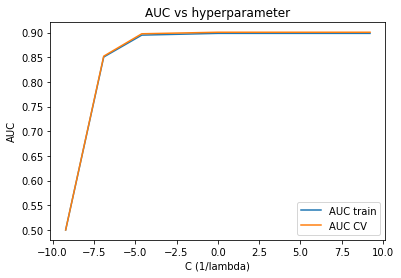

optimal lambda for which auc is maximum :  1


In [77]:
X_train_w2v=sent_vectors_train
X_cv_w2v=sent_vectors_cv
X_test_w2v=sent_vectors_test

C = [10**-4, 10**-3, 10**-2, 10**0, 10**2,10**3,10**4]
train_auc=[]
cv_auc=[]
for c in C:
    #L1 regularization
    '''Added additional parameter class_weight='balanced'. The “balanced” mode uses the values of y to automatically 
adjust weights inversely proportional to class'''
    log_regression=LogisticRegression(penalty='l1',C=c, class_weight='balanced')
    log_regression.fit(X_train_w2v,y_train)
    probcv=log_regression.predict_proba(X_cv_w2v)[:,1]
    cv_auc.append(roc_auc_score(y_cv,probcv))
    probtr=log_regression.predict_proba(X_train_w2v)[:,1]
    train_auc.append(roc_auc_score(y_train,probtr))
optimal_c= C[cv_auc.index(max(cv_auc))]
#converting values into logarithm
C=[math.log(x) for x in C]
fig = plt.figure()
axis = plt.subplot(111)
axis.plot(C, train_auc, label='AUC train')
axis.plot(C, cv_auc, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('C (1/lambda)')
plt.ylabel('AUC')
axis.legend()
plt.show()
print('optimal lambda for which auc is maximum : ',1//optimal_c)

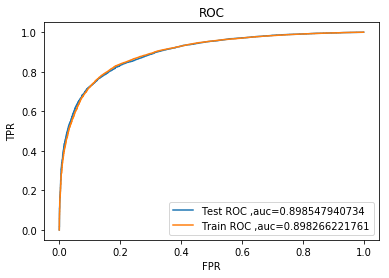

In [78]:
#ROC
'''Added additional parameter class_weight='balanced'. The “balanced” mode uses the values of y to automatically 
adjust weights inversely proportional to class'''
log_regression=LogisticRegression(penalty='l1',C=optimal_c, class_weight='balanced')
log_regression.fit(X_train_w2v,y_train)
test_predict=log_regression.predict_proba(X_test_w2v)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, test_predict)
train_predict=log_regression.predict_proba(X_train_w2v)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_train,train_predict)
fig = plt.figure()
axis = plt.subplot(111)
axis.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,test_predict)))
axis.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,train_predict)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
axis.legend()
plt.show()

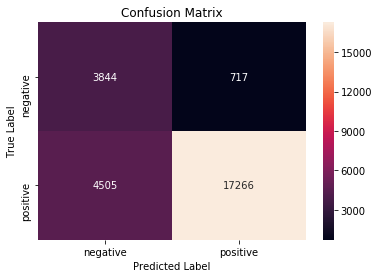

In [79]:
#confusion matrix
lr=LogisticRegression(penalty='l1',C=optimal_c, class_weight='balanced')
lr.fit(X_train_w2v,y_train)
predict=lr.predict(X_test_w2v)
conf_mat = confusion_matrix(y_test, predict)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

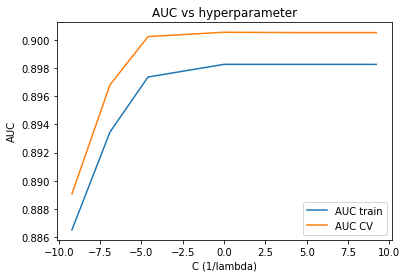

optimal lambda for which auc is maximum :  1


In [80]:
# Please write all the code with proper documentation

C = [10**-4, 10**-3, 10**-2, 10**0, 10**2,10**3,10**4]#C=1/lambda
auc_train=[]
auc_cv=[]
for c in C:
    '''Added additional parameter class_weight='balanced'. The “balanced” mode uses the values of y to automatically 
adjust weights inversely proportional to class'''
    log_regression=LogisticRegression(penalty='l2',C=c, class_weight='balanced')
    log_regression.fit(X_train_w2v,y_train)
    probcv=log_regression.predict_proba(X_cv_w2v)[:,1]
    auc_cv.append(roc_auc_score(y_cv,probcv))
    probtr=log_regression.predict_proba(X_train_w2v)[:,1]
    auc_train.append(roc_auc_score(y_train,probtr))
optimal_c= C[auc_cv.index(max(auc_cv))]
C=[math.log(x) for x in C]#converting values of C into logarithm
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(C, auc_train, label='AUC train')
ax.plot(C, auc_cv, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('C (1/lambda)')
plt.ylabel('AUC')
ax.legend()
plt.show()
print('optimal lambda for which auc is maximum : ',1//optimal_c)

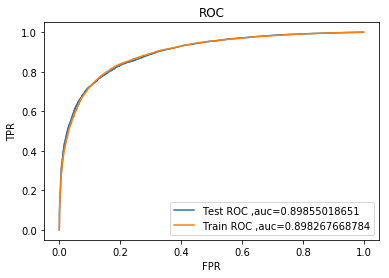

In [81]:
#ROC
'''Added additional parameter class_weight='balanced'. The “balanced” mode uses the values of y to automatically 
adjust weights inversely proportional to class'''
log_regression=LogisticRegression(penalty='l2',C=optimal_c, class_weight='balanced')
log_regression.fit(X_train_w2v,y_train)
predi=log_regression.predict_proba(X_test_w2v)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, predi)
pred=log_regression.predict_proba(X_train_w2v)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_train,pred)
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,predi)))
ax.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()

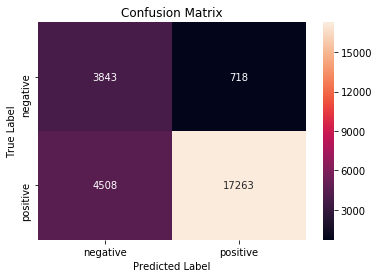

In [82]:
#Confusion matrix
lr=LogisticRegression(penalty='l2',C=optimal_c, class_weight='balanced')
lr.fit(X_train_w2v,y_train)
predict=lr.predict(X_test_w2v)
conf_mat = confusion_matrix(y_test, predict)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [83]:
# Please write all the code with proper documentation
list_of_sentance_train=[]
#Iterating over train data
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

w2v_model=Word2Vec(list_of_sentance_train,min_count=10,size=50) 
w2v_words = list(w2v_model.wv.vocab)
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10, max_features=500)
tf_idf_matrix=tf_idf_vect.fit_transform(X_train)

tfidf_feat = tf_idf_vect.get_feature_names() 
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))


In [84]:
#train data
tfidf_sent_vectors_train = []; 
row=0;
for sent in tqdm(list_of_sentance_train): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 43008/43008 [01:44<00:00, 413.24it/s]


In [85]:
#cv data
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
tfidf_sent_vectors_cv = []; 
row=0;
for sent in tqdm(list_of_sentance_cv): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 18433/18433 [00:44<00:00, 415.54it/s]


In [86]:
#test data
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
tfidf_sent_vectors_test = []; 
row=0;
for sent in tqdm(list_of_sentance_test): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 26332/26332 [01:21<00:00, 321.13it/s]


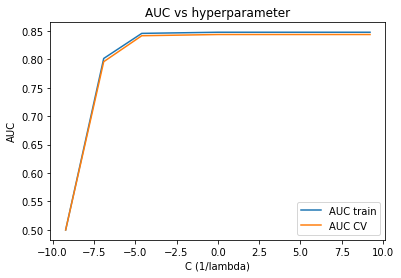

optimal lambda for which auc is maximum :  0


In [87]:
X_train_tfw2v=tfidf_sent_vectors_train
X_cv_tfw2v=tfidf_sent_vectors_cv
X_test_tfw2v=tfidf_sent_vectors_test

C = [10**-4, 10**-3, 10**-2, 10**0, 10**2,10**3,10**4]
auc_train=[]
auc_cv=[]
for c in C:
    '''Added additional parameter class_weight='balanced'. The “balanced” mode uses the values of y to automatically 
adjust weights inversely proportional to class'''
    lr=LogisticRegression(penalty='l1',C=c, class_weight='balanced')
    lr.fit(X_train_tfw2v,y_train)
    probcv=lr.predict_proba(X_cv_tfw2v)[:,1]
    auc_cv.append(roc_auc_score(y_cv,probcv))
    probtr=lr.predict_proba(X_train_tfw2v)[:,1]
    auc_train.append(roc_auc_score(y_train,probtr))
optimal_c= C[auc_cv.index(max(auc_cv))]
C=[math.log(x) for x in C]#converting values of C into logarithm
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(C, auc_train, label='AUC train')
ax.plot(C, auc_cv, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('C (1/lambda)')
plt.ylabel('AUC')
ax.legend()
plt.show()
print('optimal lambda for which auc is maximum : ',1//optimal_c)

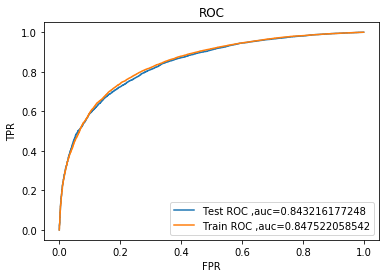

In [88]:
#ROC
'''Added additional parameter class_weight='balanced'. The “balanced” mode uses the values of y to automatically 
adjust weights inversely proportional to class'''
lr=LogisticRegression(penalty='l1',C=optimal_c, class_weight='balanced')
lr.fit(X_train_tfw2v,y_train)
predi=lr.predict_proba(X_test_tfw2v)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, predi)
pred=lr.predict_proba(X_train_tfw2v)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_train,pred)
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,predi)))
ax.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()

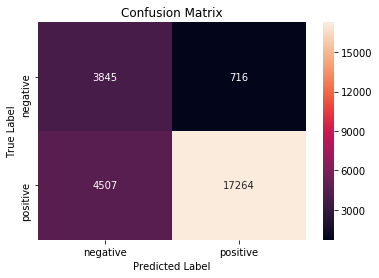

In [89]:
#Confusion matrix
lr=LogisticRegression(penalty='l1',C=optimal_c, class_weight='balanced')
lr.fit(X_train_w2v,y_train)
predict=lr.predict(X_test_w2v)
conf_matrix = confusion_matrix(y_test, predict)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_matrix, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

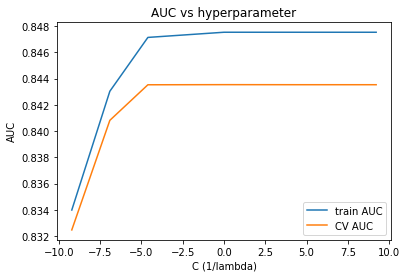

optimal lambda for which auc is maximum :  1


In [90]:
# Please write all the code with proper documentation
C = [10**-4, 10**-3, 10**-2, 10**0, 10**2,10**3,10**4]
train_auc=[]
cv_auc=[]
for c in C:
    #Applying l2 regularization
    '''Added additional parameter class_weight='balanced'. The “balanced” mode uses the values of y to automatically 
adjust weights inversely proportional to class'''
    log_regression=LogisticRegression(penalty='l2',C=c, class_weight='balanced')
    log_regression.fit(X_train_tfw2v,y_train)
    probcv=log_regression.predict_proba(X_cv_tfw2v)[:,1]
    cv_auc.append(roc_auc_score(y_cv,probcv))
    probtr=log_regression.predict_proba(X_train_tfw2v)[:,1]
    train_auc.append(roc_auc_score(y_train,probtr))
optimal_c= C[cv_auc.index(max(cv_auc))]
#Converting into log values
C=[math.log(x) for x in C]
fig = plt.figure()
axis = plt.subplot(111)
axis.plot(C, train_auc, label='train AUC')
axis.plot(C, cv_auc, label='CV AUC')
plt.title('AUC vs hyperparameter')
plt.xlabel('C (1/lambda)')
plt.ylabel('AUC')
axis.legend()
plt.show()
print('optimal lambda for which auc is maximum : ',1//optimal_c)


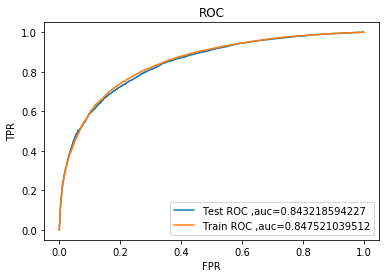

In [91]:
#ROC
'''Added additional parameter class_weight='balanced'. The “balanced” mode uses the values of y to automatically 
adjust weights inversely proportional to class'''
log_regression=LogisticRegression(penalty='l2',C=optimal_c, class_weight='balanced')
log_regression.fit(X_train_tfw2v,y_train)
test_predict=log_regression.predict_proba(X_test_tfw2v)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, test_predict)
train_predict=log_regression.predict_proba(X_train_tfw2v)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_train,train_predict)
fig = plt.figure()
axis = plt.subplot(111)
axis.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,test_predict)))
axis.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,train_predict)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
axis.legend()
plt.show()

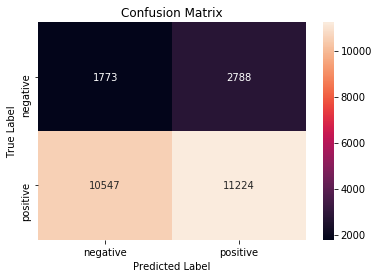

In [92]:
#Confusion matrix
lr=LogisticRegression(penalty='l2',C=optimal_c, class_weight='balanced')
y_train_26332 = y_train[0: 26332]
lr.fit(X_test_tfw2v,y_train_26332)
predict=lr.predict(X_test_tfw2v)
conf_mat = confusion_matrix(y_test, predict)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [93]:
#Feature Engineering 
#Adding preprocessed summary and review length to preprocessed summary
for i in range(len(preprocessed_reviews)):
    preprocessed_reviews[i]+=' '+preprocessed_summary[i]+' '+str(len(final.Text.iloc[i]))

preprocessed_reviews[1500]

'dogs love food service always fast reliable always great 69'

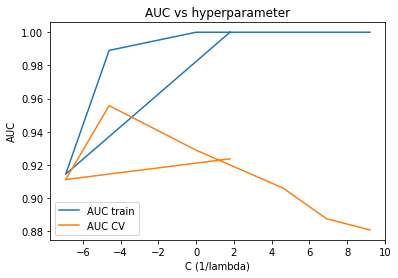

optimal lambda for which auc is maximum :  99.0


In [94]:
#Applying Logistic Regression on BoW 
X=preprocessed_reviews

y=np.array(final['Score'])
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_1, y_1, test_size=0.3)
count_vect = CountVectorizer()
X_train_bow=count_vect.fit_transform(X_train)
X_cv_bow=count_vect.transform(X_cv)
X_test_bow=count_vect.transform(X_test)

scalar = StandardScaler(with_mean=False)
X_train_bow = scalar.fit_transform(X_train_bow)
X_test_bow= scalar.transform(X_test_bow)
X_cv_bow=scalar.transform(X_cv_bow)

C = [10-4, 10**-3, 10**-2, 10**0, 10**2,10**3,10**4]
auc_train=[]
auc_cv=[]
for c in C:
    '''Added additional parameter class_weight='balanced'. The “balanced” mode uses the values of y to automatically 
adjust weights inversely proportional to class'''
    lr=LogisticRegression(penalty='l1',C=c, class_weight='balanced')
    lr.fit(X_train_bow,y_train)
    probcv=lr.predict_proba(X_cv_bow)[:,1]
    auc_cv.append(roc_auc_score(y_cv,probcv))
    probtr=lr.predict_proba(X_train_bow)[:,1]
    auc_train.append(roc_auc_score(y_train,probtr))
optimal_c= C[auc_cv.index(max(auc_cv))]
#converting values into log
C=[math.log(x) for x in C]
fig = plt.figure()
axis = plt.subplot(111)
axis.plot(C, auc_train, label='AUC train')
axis.plot(C, auc_cv, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('C (1/lambda)')
plt.ylabel('AUC')
axis.legend()
plt.show()
print('optimal lambda for which auc is maximum : ',1//optimal_c)

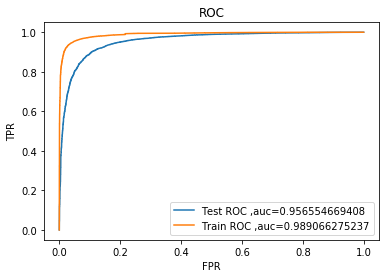

In [95]:
#ROC

'''Added additional parameter class_weight='balanced'. The “balanced” mode uses the values of y to automatically 
adjust weights inversely proportional to class'''
lr=LogisticRegression(penalty='l1',C=optimal_c, class_weight='balanced')
lr.fit(X_train_bow,y_train)
predi=lr.predict_proba(X_test_bow)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, predi)
pred=lr.predict_proba(X_train_bow)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_train,pred)
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,predi)))
ax.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()

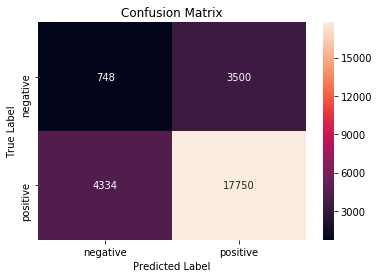

In [96]:
#Confusion matrix
lr=LogisticRegression(penalty='l2',C=optimal_c, class_weight='balanced')
y_train_26332 = y_train[0: 26332]
lr.fit(X_test_bow,y_train_26332)
predict=lr.predict(X_test_bow)
conf_mat = confusion_matrix(y_test, predict)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

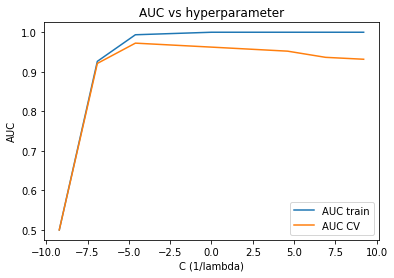

optimal lambda for which auc is maximum :  99.0


In [97]:
# After feature engineering Logistic Regression on TFIDF
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
X_train_tf=tf_idf_vect.fit_transform(X_train)
X_cv_tf=tf_idf_vect.transform(X_cv)
X_test_tf=tf_idf_vect.transform(X_test)

scalar = StandardScaler(with_mean=False)
X_train_tf = scalar.fit_transform(X_train_tf)
X_test_tf= scalar.transform(X_test_tf)
X_cv_tf=scalar.transform(X_cv_tf)

C = [10**-4, 10**-3, 10**-2, 10**0, 10**2,10**3,10**4]
auc_train=[]
auc_cv=[]
for c in C:
    #l1 regularization
    '''Added additional parameter class_weight='balanced'. The “balanced” mode uses the values of y to automatically 
adjust weights inversely proportional to class'''
    lr=LogisticRegression(penalty='l1',C=c, class_weight='balanced')
    lr.fit(X_train_tf,y_train)
    probcv=lr.predict_proba(X_cv_tf)[:,1]
    auc_cv.append(roc_auc_score(y_cv,probcv))
    probtr=lr.predict_proba(X_train_tf)[:,1]
    auc_train.append(roc_auc_score(y_train,probtr))
optimal_c= C[auc_cv.index(max(auc_cv))]
C=[math.log(x) for x in C]
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(C, auc_train, label='AUC train')
ax.plot(C, auc_cv, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('C (1/lambda)')
plt.ylabel('AUC')
ax.legend()
plt.show()
print('optimal lambda for which auc is maximum : ',1//optimal_c)

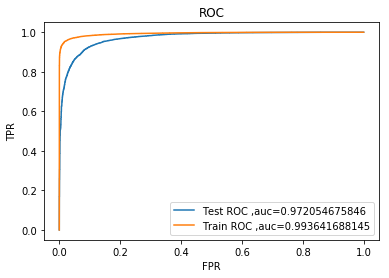

In [98]:
#ROC
'''Added additional parameter class_weight='balanced'. The “balanced” mode uses the values of y to automatically 
adjust weights inversely proportional to class'''
lr=LogisticRegression(penalty='l1',C=optimal_c, class_weight='balanced')
lr.fit(X_train_tf,y_train)
predi=lr.predict_proba(X_test_tf)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, predi)
pred=lr.predict_proba(X_train_tf)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_train,pred)
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,predi)))
ax.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()

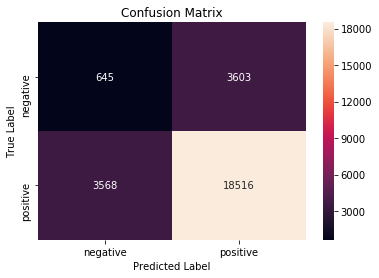

In [99]:
#Confusion matrix
lr=LogisticRegression(penalty='l2',C=optimal_c, class_weight='balanced')
y_train_26332 = y_train[0: 26332]
lr.fit(X_test_tf,y_train_26332)
predict=lr.predict(X_test_tf)
conf_mat = confusion_matrix(y_test, predict)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [110]:
# After feature engineering Logistic regression on Word2vec 
# word2vec for train
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
sent_vectors_train = []; 
for sent in tqdm(list_of_sentance_train):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|███████████████████████████████████████████████████████████████████████████| 43008/43008 [05:01<00:00, 142.46it/s]


43008
50


In [111]:
#for w2v cv data
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
sent_vectors_cv = []; 
for sent in tqdm(list_of_sentance_cv):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
           sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))   

100%|███████████████████████████████████████████████████████████████████████████| 18433/18433 [02:06<00:00, 145.96it/s]


18433
50


In [112]:
#for w2v test data
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
sent_vectors_test = []; 
for sent in tqdm(list_of_sentance_test):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 26332/26332 [03:05<00:00, 142.11it/s]


26332
50


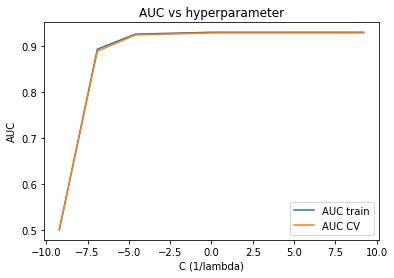

optimal lambda for which auc is maximum :  1


In [113]:
X_train_w2v=sent_vectors_train
X_cv_w2v=sent_vectors_cv
X_test_w2v=sent_vectors_test

C = [10**-4, 10**-3, 10**-2, 10**0, 10**2,10**3,10**4]
auc_train=[]
auc_cv=[]
for c in C:
    '''Added additional parameter class_weight='balanced'. The “balanced” mode uses the values of y to automatically 
adjust weights inversely proportional to class'''
    lr=LogisticRegression(penalty='l1',C=c, class_weight='balanced')
    lr.fit(X_train_w2v,y_train)
    probcv=lr.predict_proba(X_cv_w2v)[:,1]
    auc_cv.append(roc_auc_score(y_cv,probcv))
    probtr=lr.predict_proba(X_train_w2v)[:,1]
    auc_train.append(roc_auc_score(y_train,probtr))
optimal_c= C[auc_cv.index(max(auc_cv))]
C=[math.log(x) for x in C]
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(C, auc_train, label='AUC train')
ax.plot(C, auc_cv, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('C (1/lambda)')
plt.ylabel('AUC')
ax.legend()
plt.show()
print('optimal lambda for which auc is maximum : ',1//optimal_c)

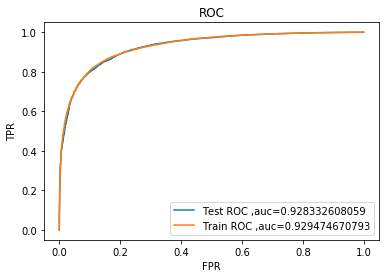

In [114]:
#ROC
'''Added additional parameter class_weight='balanced'. The “balanced” mode uses the values of y to automatically 
adjust weights inversely proportional to class'''
lr=LogisticRegression(penalty='l1',C=optimal_c, class_weight='balanced')
lr.fit(X_train_w2v,y_train)
predi=lr.predict_proba(X_test_w2v)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, predi)
pred=lr.predict_proba(X_train_w2v)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_train,pred)
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,predi)))
ax.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()

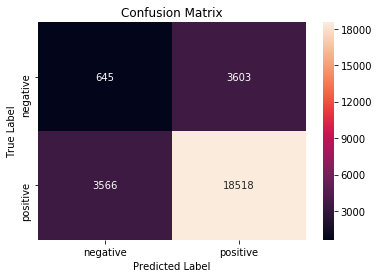

In [126]:
#Confusion matrix

lr=LogisticRegression(penalty='l2',C=optimal_c, class_weight='balanced')
y_train_26332 = y_train[0: 26332]
lr.fit(X_test_tf,y_train_26332)
predict=lr.predict(X_test_w2v)
conf_mat = confusion_matrix(y_test, predict)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [127]:
# After feature engineering Logistic Regression on Avg TFIDF W2vec
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4) 
w2v_words = list(w2v_model.wv.vocab)
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10, max_features=500)

tf_idf_matrix=tf_idf_vect.fit_transform(X_train)


tfidf_feat = tf_idf_vect.get_feature_names() 
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))




In [128]:
#for train data

tfidf_sent_vectors_train = []; 
row=0;
for sent in tqdm(list_of_sentance_train): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 43008/43008 [03:40<00:00, 195.11it/s]


In [129]:
#for cross validation data and test we will use same words and models of train
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
tfidf_sent_vectors_cv = []; 
row=0;
for sent in tqdm(list_of_sentance_cv): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 18433/18433 [01:47<00:00, 170.94it/s]


In [130]:
#for test data
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
tfidf_sent_vectors_test = []; 
row=0;
for sent in tqdm(list_of_sentance_test): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 26332/26332 [02:42<00:00, 161.77it/s]


X_train_tfw2v =  43008
X_cv_tfw2v =  18433
X_test_tfw2v =  26332


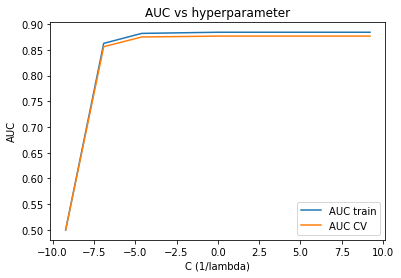

optimal lambda for which auc is maximum :  0


In [149]:
X_train_tfw2v=tfidf_sent_vectors_train
X_cv_tfw2v=tfidf_sent_vectors_cv
X_test_tfw2v=tfidf_sent_vectors_test
#print (type(X_train_tfw2v))


print ("X_train_tfw2v = ",len(X_train_tfw2v))
print ('X_cv_tfw2v = ',len(X_cv_tfw2v))
print ('X_test_tfw2v = ',len(X_test_tfw2v))

C = [10**-4, 10**-3, 10**-2, 10**0, 10**2,10**3,10**4]
auc_train=[]
auc_cv=[]
for c in C:
    '''Added additional parameter class_weight='balanced'. The “balanced” mode uses the values of y to automatically 
adjust weights inversely proportional to class'''
    lr=LogisticRegression(penalty='l1',C=c, class_weight='balanced')
    lr.fit(X_train_tfw2v,y_train)
    probcv=lr.predict_proba(X_cv_tfw2v)[:,1]
    auc_cv.append(roc_auc_score(y_cv,probcv))
    probtr=lr.predict_proba(X_train_tfw2v)[:,1]
    auc_train.append(roc_auc_score(y_train,probtr))
optimal_c= C[auc_cv.index(max(auc_cv))]
C=[math.log(x) for x in C]#converting values of C into logarithm
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(C, auc_train, label='AUC train')
ax.plot(C, auc_cv, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('C (1/lambda)')
plt.ylabel('AUC')
ax.legend()
plt.show()
print('optimal lambda for which auc is maximum : ',1//optimal_c)

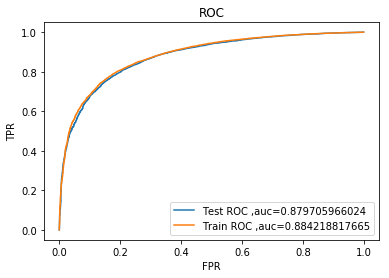

In [137]:
#ROC
'''Added additional parameter class_weight='balanced'. The “balanced” mode uses the values of y to automatically 
adjust weights inversely proportional to class'''
lr=LogisticRegression(penalty='l1',C=optimal_c, class_weight='balanced')
lr.fit(X_train_tfw2v,y_train)
predi=lr.predict_proba(X_test_tfw2v)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, predi)
pred=lr.predict_proba(X_train_tfw2v)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_train,pred)
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,predi)))
ax.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()

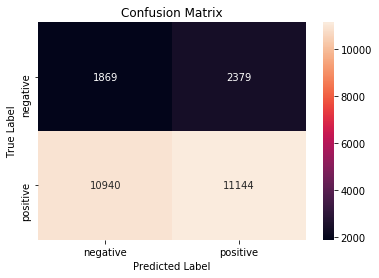

In [153]:
#Confusion matrix
lr=LogisticRegression(penalty='l2',C=optimal_c, class_weight='balanced')
y_train_26332 = y_train[0:26332]
lr.fit(X_test_tfw2v,y_train_26332)
predict=lr.predict(X_test_tfw2v)
conf_mat = confusion_matrix(y_test, predict)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# [6] Conclusions

In [154]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable    
ptable = PrettyTable()
ptable.field_names = ["Model","Regularization", "Feature engineering Applied (Yes/No)", "Hyperameter(lambda)", "AUC"]
ptable.add_row(["BOW","l1","No",99,0.938])
ptable.add_row(["BOW","l2","No",999,0.982])
ptable.add_row(["TFIDF","l1","No",99,0.918])
ptable.add_row(["TFIDF","l2","No",9999,0.994])
ptable.add_row(["Avg W2v","l1","No",0,0.960])
ptable.add_row(["Avg W2v","l2","No",1,0.990])
ptable.add_row(["TFIDF Avg W2v","l1","No",0,0.955])
ptable.add_row(["TFIDF Avg W2v","l2","No",0,0.998])
ptable.add_row(["BOW","l1","Yes",99,0.989])
ptable.add_row(["TFIDF","l1","Yes",99,0.974])
ptable.add_row(["Avg W2v","l1","Yes",0,0.942])
ptable.add_row(["Avg W2v","l1","Yes",1,0.929])
print(ptable)

+---------------+----------------+--------------------------------------+---------------------+-------+
|     Model     | Regularization | Feature engineering Applied (Yes/No) | Hyperameter(lambda) |  AUC  |
+---------------+----------------+--------------------------------------+---------------------+-------+
|      BOW      |       l1       |                  No                  |          99         | 0.938 |
|      BOW      |       l2       |                  No                  |         999         | 0.982 |
|     TFIDF     |       l1       |                  No                  |          99         | 0.918 |
|     TFIDF     |       l2       |                  No                  |         9999        | 0.994 |
|    Avg W2v    |       l1       |                  No                  |          0          |  0.96 |
|    Avg W2v    |       l2       |                  No                  |          1          |  0.99 |
| TFIDF Avg W2v |       l1       |                  No          